In [3]:
# Installer XGBoost si nécessaire
!pip install xgboost

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Chargement du dataset fusionné (climatique + production)
df = pd.read_csv("donnees_finales_datadriven.csv")

# Définir X et y
X = df.drop(columns=['production_tonnes'])
y = df['production_tonnes']

# Identifier colonnes catégorielles
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Prétraitement (encodage des variables catégorielles)
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Pipeline avec XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# ⚠️ Nettoyage : retirer lignes avec NaN ou valeurs infinies
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Fusionner pour enlever lignes où X ou y est NaN
df_clean = pd.concat([X, y], axis=1).dropna()

# Séparer de nouveau
X = df_clean.drop(columns=['production_tonnes'])
y = df_clean['production_tonnes']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("📊 Évaluation du modèle XGBoost :")
print("MAE :", round(mae, 2))
print("RMSE :", round(rmse, 2))
print("R² :", round(r2, 4))


📊 Évaluation du modèle XGBoost :
MAE : 36068.63
RMSE : 95579.95
R² : 0.9862


<ipython-input-5-ebf9403a41ae>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='viridis')


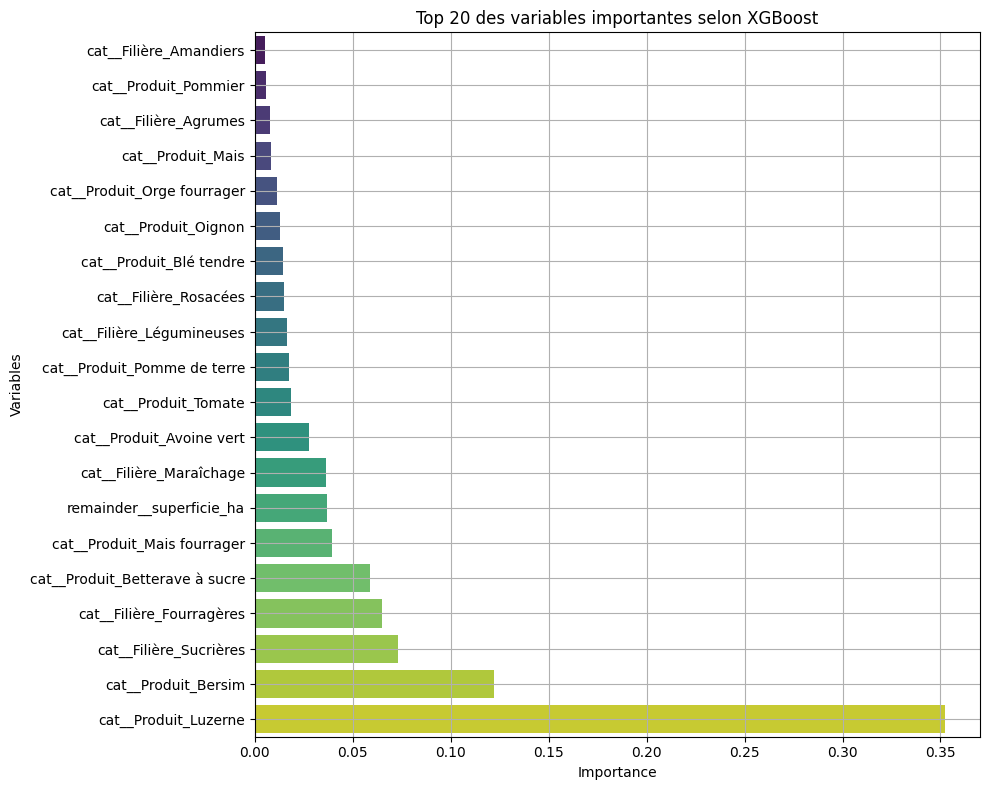

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Récupérer le modèle XGBoost entraîné à l'intérieur du pipeline
xgb_model = model.named_steps['regressor']

# Extraire les noms des variables transformées
encoded_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = xgb_model.feature_importances_

# Créer DataFrame trié
feat_importances = pd.Series(importances, index=encoded_feature_names)
feat_importances = feat_importances.sort_values(ascending=True).tail(20)  # Top 20

# Affichage
plt.figure(figsize=(10, 8))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='viridis')
plt.title("Top 20 des variables importantes selon XGBoost")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()
